### fonctions utilisées

In [57]:
from sqlalchemy import create_engine, text
from sqlalchemy.engine import Engine
from typing import Optional, List, Dict, Any
import pandas as pd
import os
import yaml
from pathlib import Path
from dotenv import load_dotenv

load_dotenv(r"C:\Users\DELL\Documents\vscode_simplon\Brief-2-ETL-de-donn-es-footballistiques-Wickets-Sprinters\.env")

def load_env(env_file: str = ".env") -> None:
    """
    Load environment variables from a .env file.
    Works in both script and notebook environments.
    """

    env_path = Path(env_file)

    if not env_path.is_absolute():
        # Script
        if "__file__" in globals():
            project_root = Path(__file__).resolve().parents[1]
        # Notebook
        else:
            project_root = Path.cwd()

        env_path = project_root / env_path

    if not env_path.exists():
        raise FileNotFoundError(f"❌ .env file not found: {env_path}")
    
    # load_dotenv(env_path)

def fct_load_config(config_filename: str = "config.yaml") -> dict:
    """
    Goal
    ----
    Load configuration parameters from a YAML file.

    This function works both in:
    - Python scripts
    - Jupyter notebooks (where __file__ is not defined)

    Parameters
    ----------
    config_filename : str
        Relative or absolute path to the YAML configuration file.

    Returns
    -------
    dict
        Dictionary containing configuration parameters.
    """

    config_path = Path(config_filename)

    # Cas 1 : chemin absolu → on l'utilise directement
    if config_path.is_absolute():
        final_path = config_path

    else:
        # Cas 2 : Script Python (__file__ existe)
        if "__file__" in globals():
            project_root = Path(__file__).resolve().parents[1]

        # Cas 3 : Notebook Jupyter (__file__ n'existe pas)
        else:
            project_root = Path(os.getcwd())

        final_path = project_root / config_path

    if not final_path.exists():
        raise FileNotFoundError(f"❌ Config file not found: {final_path}")

    with open(final_path, "r", encoding="utf-8") as f:
        config = yaml.safe_load(f)

    return config


def create_postgres_engine(
    host: str,
    database: str,
    user: str,
    password: str,
    port: int = 5432
) -> Optional[Engine]:
    """
    Crée un moteur SQLAlchemy pour PostgreSQL.

    Paramètres
    ----------
    host : str
        Adresse du serveur PostgreSQL
    database : str
        Nom de la base de données
    user : str
        Utilisateur PostgreSQL
    password : str
        Mot de passe
    port : int, optionnel
        Port PostgreSQL (par défaut 5432)

    Retour
    ------
    sqlalchemy.engine.Engine | None
        Moteur SQLAlchemy ou None en cas d'erreur
    """
    try:
        engine = create_engine(
            f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}",
            pool_pre_ping=True
        )
        return engine
    except Exception as e:
        print(f"❌ Erreur de création du moteur SQLAlchemy : {e}")
        return None


def execute_select(
    engine: Engine,
    query: str,
    params: dict | None = None
) -> List[Dict[str, Any]]:
    """
    Exécute une requête SELECT et retourne les résultats sous forme de dictionnaires.
    """
    with engine.connect() as conn:
        result = conn.execute(text(query), params or {})
        return [dict(row._mapping) for row in result]
    
def select_to_dataframe(
    engine: Engine,
    query: str,
    params: dict | None = None
) -> pd.DataFrame:
    """
    Exécute une requête SELECT et retourne un DataFrame pandas.
    """
    return pd.read_sql(text(query), engine, params=params)


def execute_query(
    engine: Engine,
    query: str,
    params: dict | None = None
) -> None:
    """
    Exécute une requête INSERT, UPDATE ou DELETE.
    """
    try:
        with engine.begin() as conn:  # commit automatique
            conn.execute(text(query), params or {})
    except Exception as e:
        print(f"❌ Erreur SQL : {e}")


def dataframe_to_table(
    df: pd.DataFrame,
    table_name: str,
    engine: Engine,
    schema: str = "public",
    if_exists: str = "append"
) -> None:
    """
    Insère un DataFrame pandas dans une table PostgreSQL.
    """
    df.to_sql(
        table_name,
        engine,
        schema=schema,
        if_exists=if_exists,
        index=False,
        method="multi"
    )


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [59]:
load_dotenv()
host=os.getenv("HOST")
database=os.getenv("DATABASE")
user=os.getenv("DB_USER")
password=os.getenv("PASSWORD")


engine = create_postgres_engine(
    host=host,
    database=database,
    user=user,
    password=password
)

### Requetes

#### Nombre total de matchs par édition

In [60]:
req1 = """SELECT edition, COUNT(*) AS total_matchs
FROM matches
GROUP BY edition
ORDER BY edition;"""

df_req1 = select_to_dataframe(
    engine,
    req1
)
df_req1

,edition,total_matchs
0,1930,18
1,1933,5
2,1934,38
3,1937,14
4,1938,26
5,1949,23
6,1950,27
7,1953,34
8,1954,49
9,1956,4


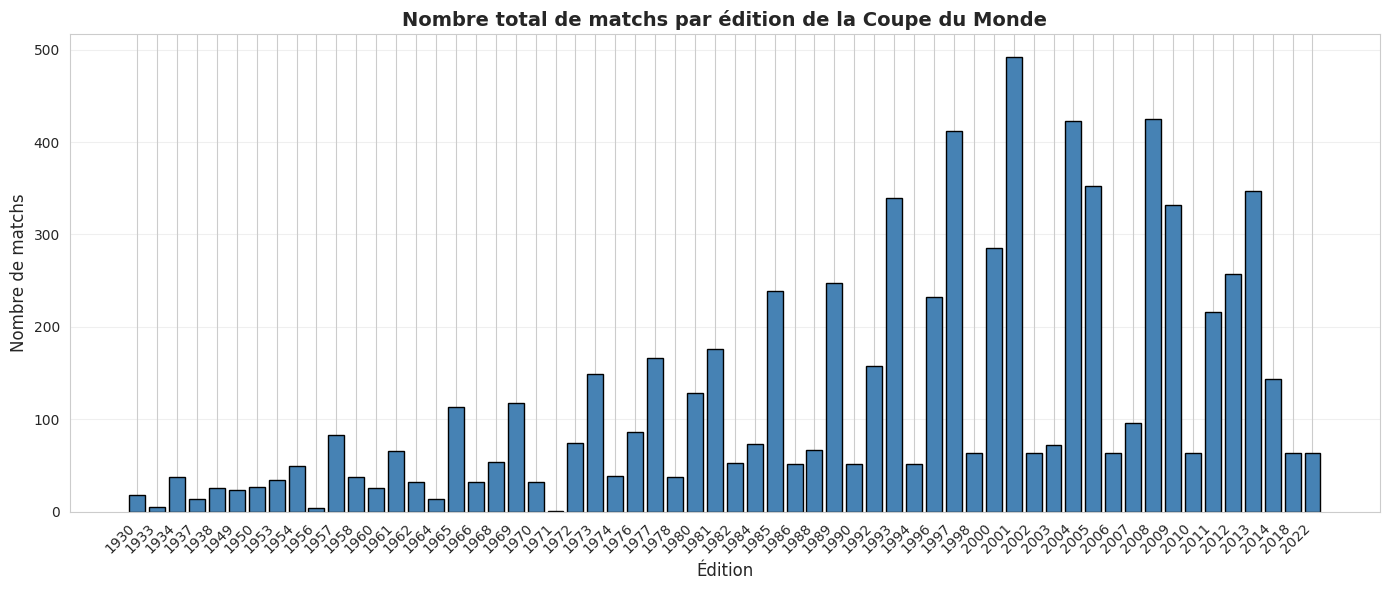

In [61]:
plt.figure(figsize=(14, 6))
plt.bar(df_req1['edition'], df_req1['total_matchs'], color='steelblue', edgecolor='black')
plt.xlabel('Édition', fontsize=12)
plt.ylabel('Nombre de matchs', fontsize=12)
plt.title('Nombre total de matchs par édition de la Coupe du Monde', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Nombre de buts marqués par édition

In [62]:
req2 = """SELECT edition,
       SUM(home_result + away_result) AS total_buts
       FROM matches
       WHERE home_result <> -999 
       AND away_result <> -999
       GROUP BY edition
       ORDER BY edition;
"""

df_req2 = select_to_dataframe(
    engine,
    req2
)
df_req2

,edition,total_buts
0,1930,70.0
1,1933,19.0
2,1934,190.0
3,1937,62.0
4,1938,106.0
5,1949,119.0
6,1950,101.0
7,1953,131.0
8,1954,217.0
9,1956,26.0


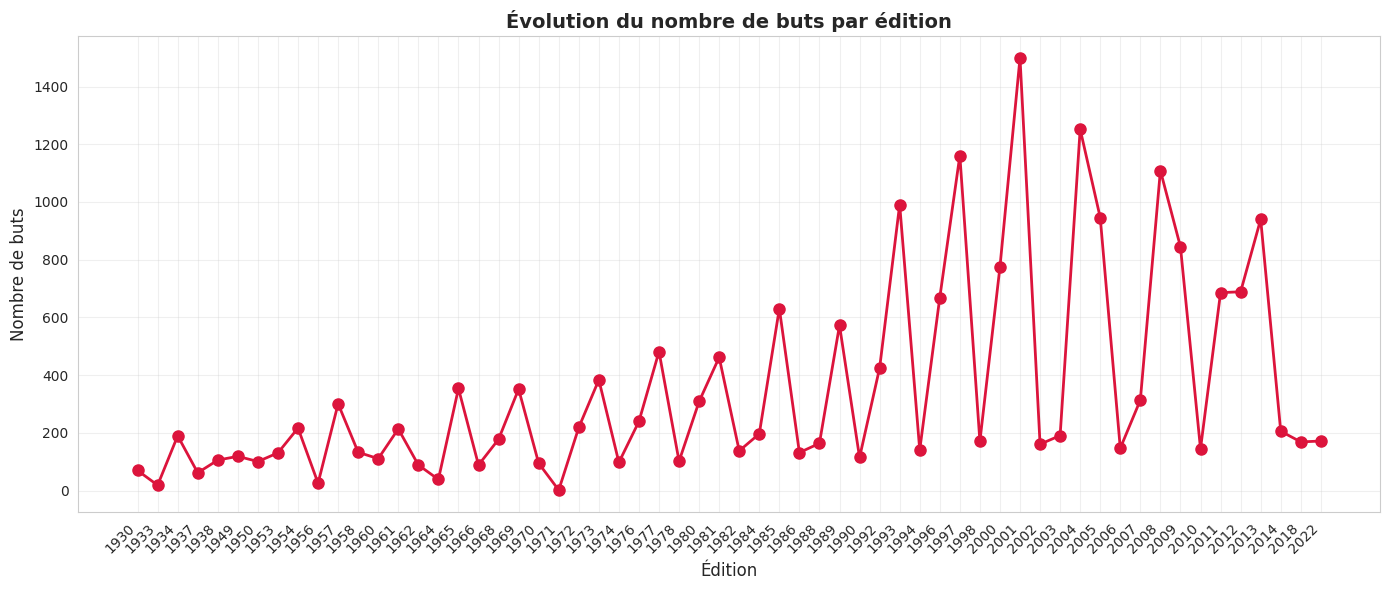

In [63]:
plt.figure(figsize=(14, 6))
plt.plot(df_req2['edition'], df_req2['total_buts'], marker='o', linewidth=2, markersize=8, color='crimson')
plt.xlabel('Édition', fontsize=12)
plt.ylabel('Nombre de buts', fontsize=12)
plt.title('Évolution du nombre de buts par édition', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Moyenne de buts par match

In [64]:
df_req3 = """ SELECT ROUND(AVG(home_result + away_result), 2) AS moyenne_buts_par_match
FROM matches
WHERE home_result <> -999 
AND away_result <> -999; """

df_req3 = select_to_dataframe(
    engine,
    df_req3
)
df_req3

,moyenne_buts_par_match
0,2.84


#### Nombre de matchs joués par ville

In [65]:
df_req4 = """SELECT edition, city, COUNT(*) AS total_matchs
FROM matches
where edition <> '2022'
GROUP BY edition, city
ORDER BY total_matchs DESC;"""

df_req4 = select_to_dataframe(
    engine,
    df_req4
)
df_req4

,edition,city,total_matchs
0,1993,Doha,25
1,2007,Apia,24
2,1989,Singapore,19
3,2012,Honiara,18
4,1930,Montevideo,18
...,...,...,...
3483,2004,Road Town,1
3484,2000,Warszawa,1
3485,2005,San_Luis_Potosí,1
3486,2000,Ljubljana,1


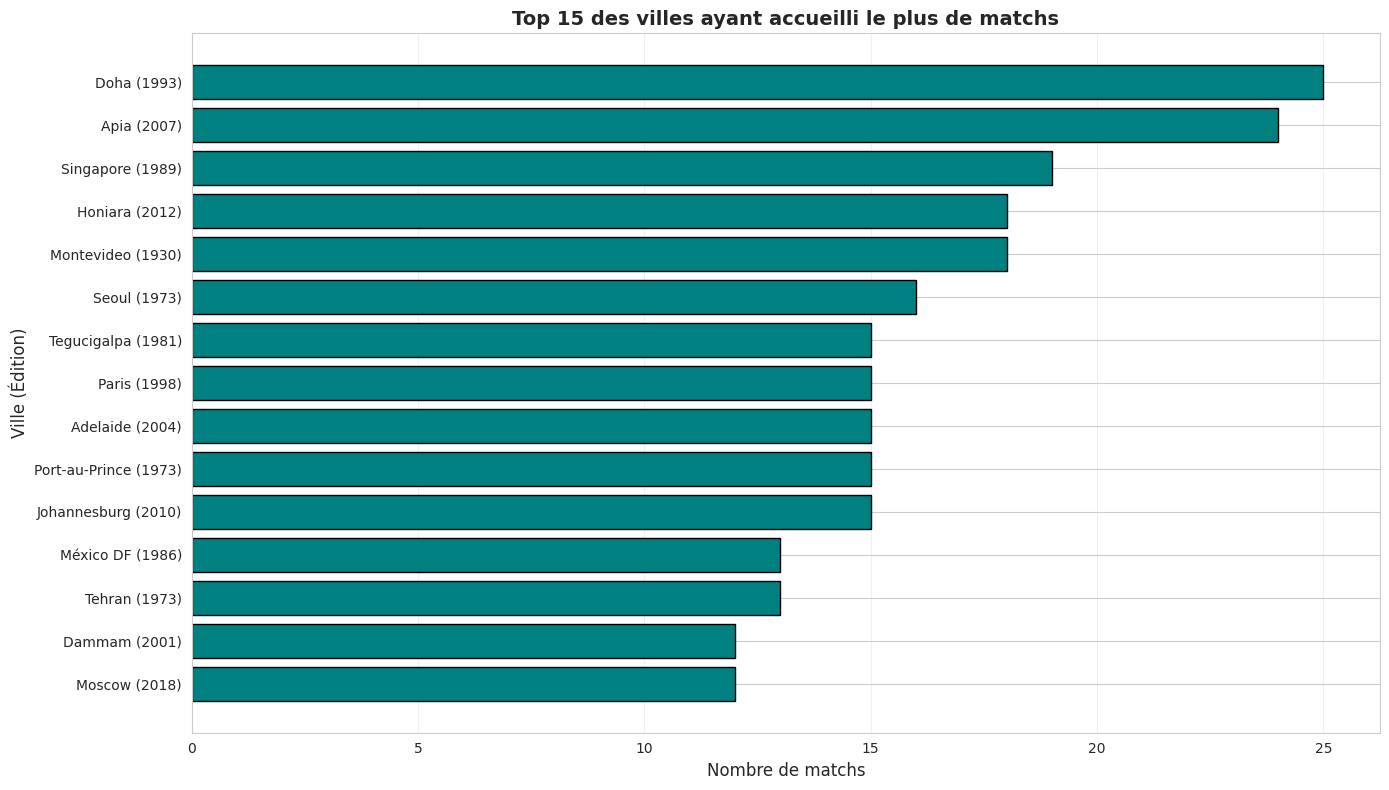

In [66]:
# Top 15 villes avec le plus de matchs
top_cities = df_req4.nlargest(15, 'total_matchs')

plt.figure(figsize=(14, 8))
plt.barh(range(len(top_cities)), top_cities['total_matchs'], color='teal', edgecolor='black')
plt.yticks(range(len(top_cities)), [f"{row['city']} ({row['edition']})" for _, row in top_cities.iterrows()])
plt.xlabel('Nombre de matchs', fontsize=12)
plt.ylabel('Ville (Édition)', fontsize=12)
plt.title('Top 15 des villes ayant accueilli le plus de matchs', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### Nombre des matches par résultat

In [67]:
df_req5 = """ SELECT
    CASE
        WHEN home_result = away_result THEN 'draw'
        WHEN home_result > away_result THEN 'win'
        ELSE 'lose'
    END AS type_match,
    COUNT(*) AS total_matchs
FROM matches
WHERE home_result <> -999 
AND away_result <> -999
GROUP BY type_match;"""

df_req5 = select_to_dataframe(
    engine,
    df_req5
)
df_req5

,type_match,total_matchs
0,draw,1598
1,lose,1972
2,win,3839


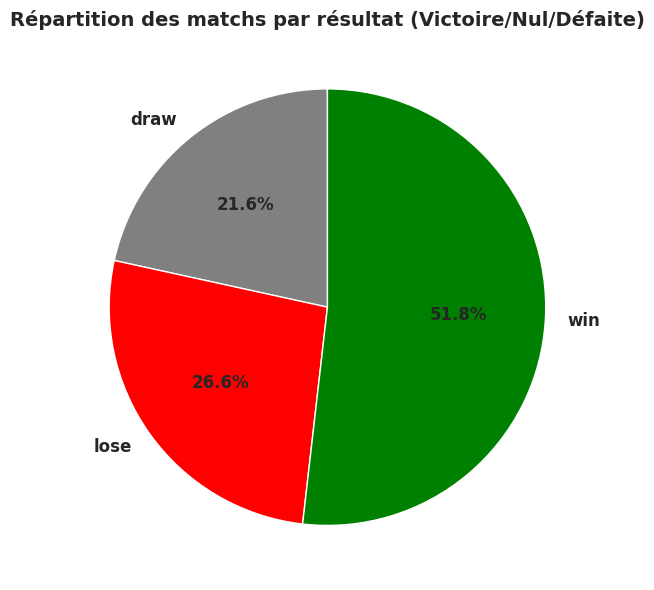

In [68]:
colors = {'win': 'green', 'draw': 'gray', 'lose': 'red'}
color_list = [colors[t] for t in df_req5['type_match']]

plt.figure(figsize=(10, 6))
plt.pie(df_req5['total_matchs'], labels=df_req5['type_match'], autopct='%1.1f%%', 
        colors=color_list, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Répartition des matchs par résultat (Victoire/Nul/Défaite)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Les 10 Matchs avec les plus de buts

In [71]:
df_req6 = """SELECT edition,stage, home_team, away_team,
       home_result, away_result,
       (home_result + away_result) AS total_buts
FROM matches
WHERE home_result <> -999 
AND away_result <> -999
ORDER BY total_buts DESC
LIMIT 10;"""

df_req6 = select_to_dataframe(
    engine,
    df_req6
    )
df_req6

,edition,stage,home_team,away_team,home_result,away_result,total_buts
0,1954,quarter_finals,Austria,Switzerland,7,5,12
1,1957,preliminary,Belgium,Iceland,8,3,11
2,1949,preliminary,England,Northern Ireland,9,2,11
3,1954,group_stage,Hungary,FRG,8,3,11
4,1938,first,Brazil,Poland,6,5,11
5,1953,preliminary,Austria,Portugal,9,1,10
6,1958,group_stage,France,Paraguay,7,3,10
7,1934,preliminary,Luxembourg,Germany,1,9,10
8,1949,preliminary,Northern Ireland,Scotland,2,8,10
9,1968,preliminary,Yugoslavia,Finland,9,1,10


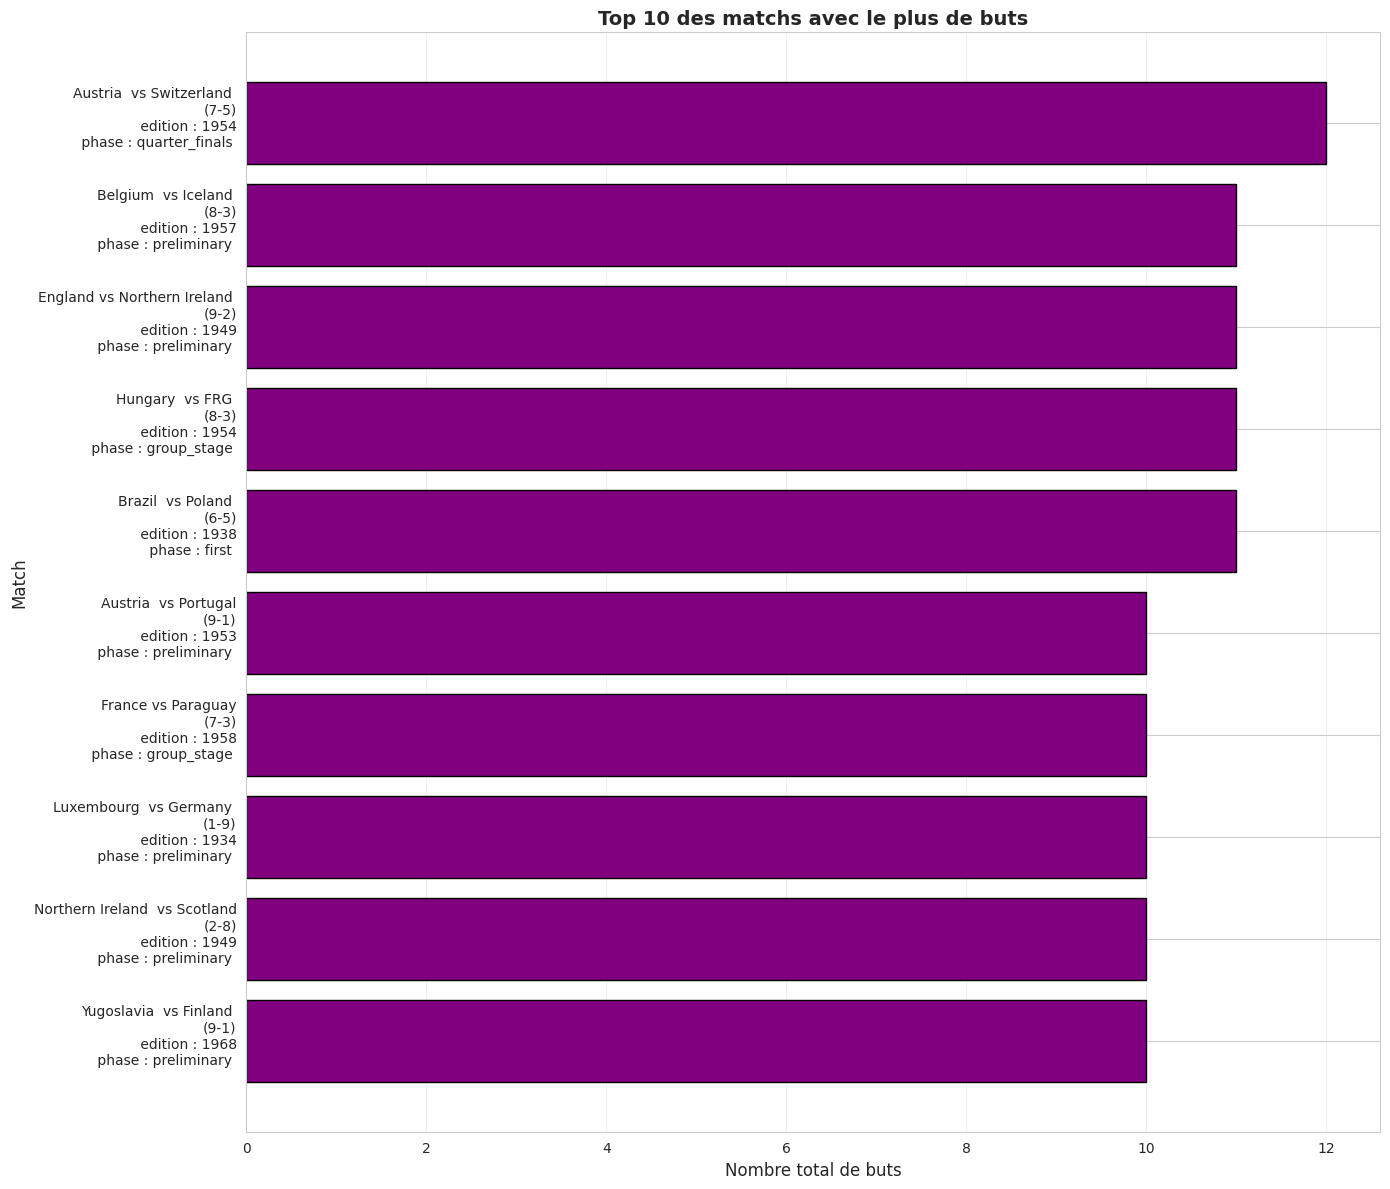

In [93]:
match_labels = [f"{row['home_team']} vs {row['away_team']}\n({row['home_result']}-{row['away_result']})\n edition : {row['edition']}\n phase : {row['stage']} \n" 
                for _, row in df_req6.iterrows()]

plt.figure(figsize=(14, 12))
plt.barh(range(len(df_req6)), df_req6['total_buts'], color='purple', edgecolor='black')
plt.yticks(range(len(df_req6)), match_labels)
plt.xlabel('Nombre total de buts', fontsize=12)
plt.ylabel('Match', fontsize=12)
plt.title('Top 10 des matchs avec le plus de buts', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#### Total de buts marqués par équipe

In [101]:
df_req7 = """
SELECT team, SUM(buts) AS total_buts
FROM (
    SELECT home_team AS team, home_result AS buts FROM matches
    WHERE home_result <> -999 

    UNION ALL
    SELECT away_team AS team, away_result AS buts FROM matches
    WHERE away_result <> -999
) t
GROUP BY team
ORDER BY total_buts DESC;
"""

df_req7 = select_to_dataframe(engine, df_req7)
df_req7

,team,total_buts
0,Mexico,450.0
1,Brazil,409.0
2,Argentina,369.0
3,England,361.0
4,Netherlands,346.0
...,...,...
268,Wales,1.0
269,Qatar,1.0
270,South Vietnam,1.0
271,Dutch East Indies,0.0


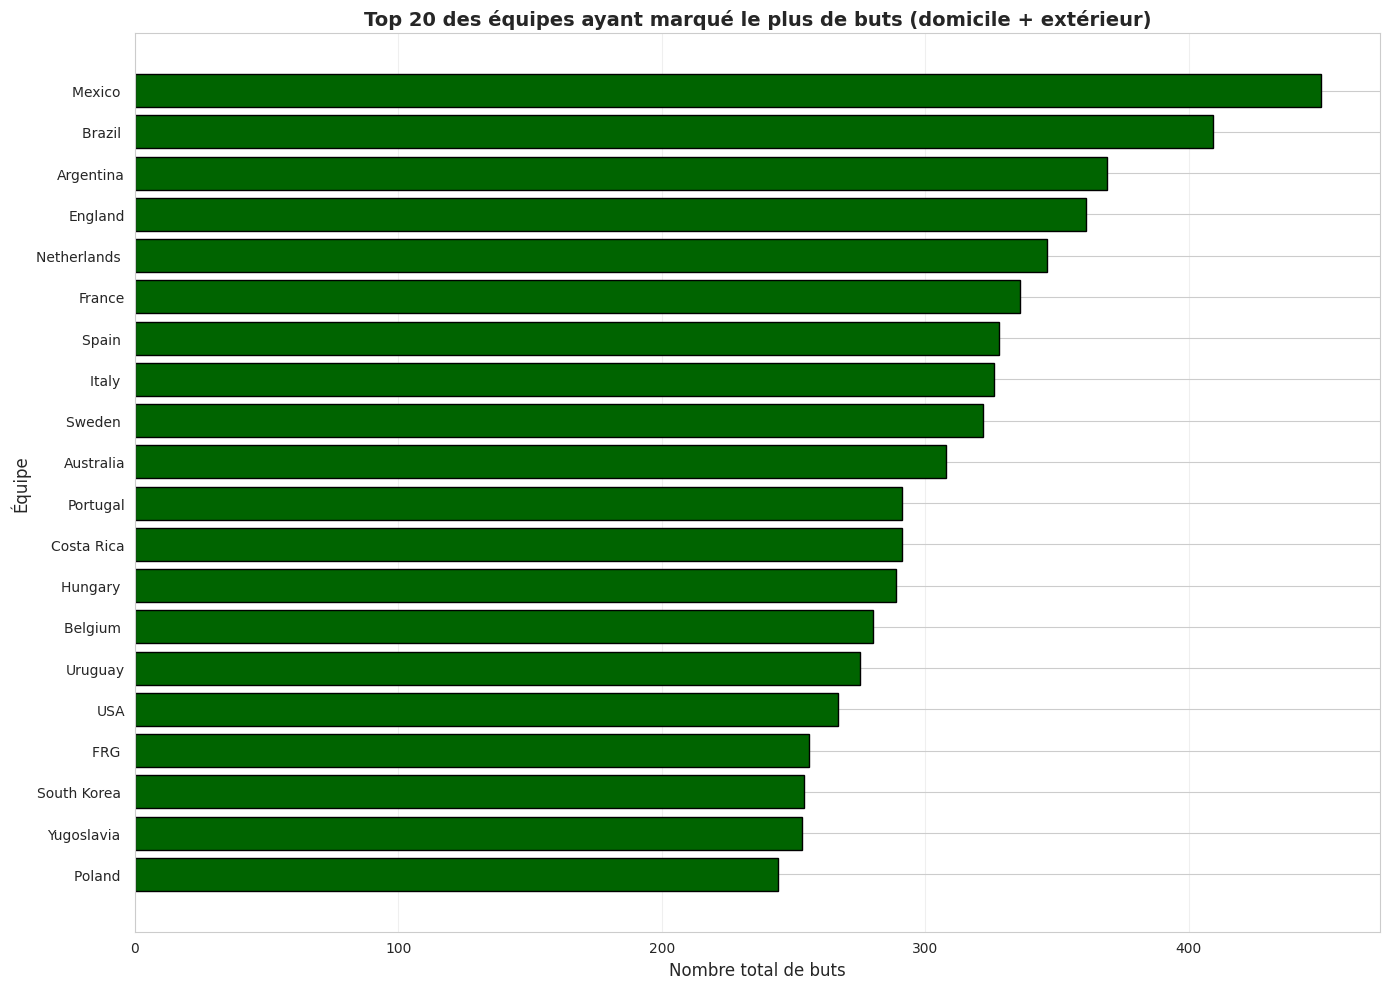

In [102]:
# Top 20 équipes avec le plus de buts
top_teams = df_req7.nlargest(20, 'total_buts')

# Visualisation
plt.figure(figsize=(14, 10))
plt.barh(range(len(top_teams)), top_teams['total_buts'], color='darkgreen', edgecolor='black')
plt.yticks(range(len(top_teams)), top_teams['team'])
plt.xlabel('Nombre total de buts', fontsize=12)
plt.ylabel('Équipe', fontsize=12)
plt.title('Top 20 des équipes ayant marqué le plus de buts (domicile + extérieur)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()